<a href="https://colab.research.google.com/github/lazybuttrying/TensorFlow-Certificate/blob/main/C4/W2/ungraded_labs/C4_W2_Lab_2_single_layer_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

**Note:** This notebook can run using TensorFlow 2.5.0

In [ ]:
#!pip install tensorflow==2.5.0

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.6.0


In [2]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [3]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series) # create dataset from series
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True) # window크기, shift, drop여부
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1)) # for easy training, flatten the data (window크기+1 크기의 chunk로)
  dataset = dataset.shuffle(shuffle_buffer) # shuffle : suffle_buffer를 쓰면 섞는데 걸리는 시간 단축
              .map(lambda window: (window[:-1], window[-1])) # 마지막 것은 label y로 나머지는 x
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [4]:

dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(dataset)
l0 = tf.keras.layers.Dense(1, input_shape=[window_size])
model = tf.keras.models.Sequential([l0]) # sole layer

# mean squared error 이용
# Stochastic Gradient Descent 이용 : 함수를 넣어서 parameter 지정 가능
# 이를 통해 모델이 좀 더 빠르고 정확하게 수렴
model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9))
# dataset에 이미 x,y로 나눠둠
model.fit(dataset,epochs=100, verbose=0)

print("Layer weights {}".format(l0.get_weights()))
# 전형적인 Simple Linear Regression의 모습을 보임
# x가 총 20개라 20개의 weight가 있음

<PrefetchDataset shapes: ((None, None), (None,)), types: (tf.float32, tf.float32)>
Layer weights [array([[-0.10641547],
       [ 0.08974025],
       [ 0.00795736],
       [ 0.00633798],
       [-0.008432  ],
       [ 0.04649547],
       [-0.10764274],
       [ 0.05443876],
       [ 0.00902915],
       [ 0.04683072],
       [-0.02426745],
       [-0.02260838],
       [-0.06429443],
       [ 0.09643162],
       [ 0.00044984],
       [-0.02339136],
       [ 0.09594643],
       [ 0.1782273 ],
       [ 0.33792615],
       [ 0.36757493]], dtype=float32), array([0.01836391], dtype=float32)]


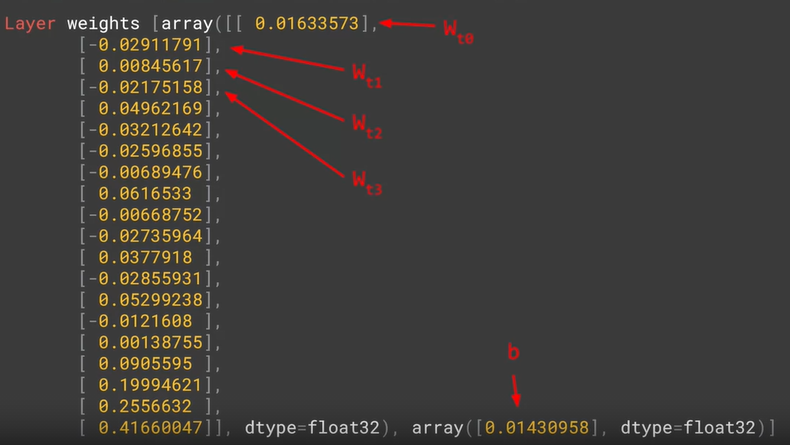

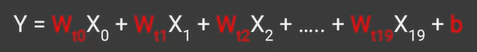

In [8]:
print(series[1:21]) # x 데이터 보기
model.predict(series[1:21][np.newaxis]) 
  # newaxis로 새로운 축/차원 추가

[49.35275  53.314735 57.711823 48.934444 48.931244 57.982895 53.897125
 47.67393  52.68371  47.591717 47.506374 50.959415 40.086178 40.919415
 46.612473 44.228207 50.720642 44.454983 41.76799  55.980938]


array([[47.633087]], dtype=float32)

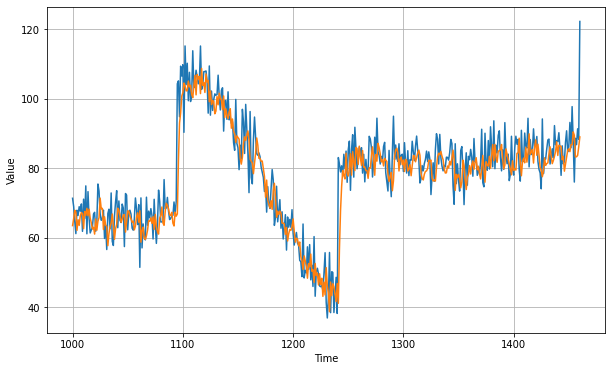

In [5]:
forecast = []

for time in range(len(series) - window_size): # drop이니 window 크기만큼 뺄셈
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

# 파란색은 실제값, 주황색은 예측값

In [6]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

5.069719